In [2]:
import sys
import os
import io
import torch
import numpy as np
from datetime import datetime
from PIL import Image
import argparse
from huggingface_hub import snapshot_download
from diffusers.image_processor import VaeImageProcessor
from IPython.display import display

# Add CatVTON directory to sys.path
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, ".."))
catvton_dir = os.path.join(parent_dir, "CatVTON")
if catvton_dir not in sys.path:
    sys.path.insert(0, catvton_dir)

from model.cloth_masker import AutoMasker, vis_mask
from model.pipeline import CatVTONPipeline
from utils import init_weight_dtype, resize_and_crop, resize_and_padding

def image_grid(images, rows, cols):
    if not images:
        return None
    # 모든 이미지의 최대 width와 height 계산
    widths, heights = zip(*(i.size for i in images))
    max_width, max_height = max(widths), max(heights)
    grid_img = Image.new('RGB', (cols * max_width, rows * max_height))
    for idx, img in enumerate(images):
        row = idx // cols
        col = idx % cols
        grid_img.paste(img, (col * max_width, row * max_height))
    return grid_img

# 기본 설정값 (변수 선언)
output_dir = "./output"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# repo_path 설정: attn_ckpt와 AutoMasker에서 사용
repo_path = snapshot_download(repo_id="zhengchong/CatVTON")

def tryon_and_vis(weights, person_image_path, cloth_image_path, cloth_type):
    # 파이프라인 인스턴스 생성
    pipeline = CatVTONPipeline(
        base_ckpt="booksforcharlie/stable-diffusion-inpainting",
        attn_ckpt="zhengchong/CatVTON",  # 학습된 try-on 모델 체크포인트 경로
        attn_ckpt_version=weights,
        weight_dtype=init_weight_dtype("bf16"),
        use_tf32=True,
        device="cuda" if torch.cuda.is_available() else "cpu"
    )

    # AutoMasker 및 mask_processor 설정
    mask_processor = VaeImageProcessor(
        vae_scale_factor=8, 
        do_normalize=False, 
        do_binarize=True, 
        do_convert_grayscale=True
    )
    automasker = AutoMasker(
        densepose_ckpt=os.path.join(repo_path, "DensePose"),
        schp_ckpt=os.path.join(repo_path, "SCHP"),
        device='cuda' if torch.cuda.is_available() else 'cpu'
    )

    # 직접 Notebook에서 실행하기 위한 변수들
    # person_image_path = "C:/Users/coldbrew/VTON-project/sample_img/sample01.jpg"   # 변경: 사람 이미지 경로 입력
    # cloth_image_path  = "C:/Users/coldbrew/VTON-project/sample_img/lower/lower01.png" # 변경: 옷 이미지 경로 입력

    # choices=["upper", "lower", "overall"]
    # cloth_type = choices[1]
    cloth_type = cloth_type
    
    num_inference_steps = 50
    guidance_scale = 2.5
    seed = -1  # -1이면 랜덤, 아니면 고정 시드
    # show_type 옵션: "result only", "input & result", "full"
    show_type = "full"


    # 이미지 로드 및 전처리
    try:
        person_img = Image.open(person_image_path).convert("RGB")
        cloth_img = Image.open(cloth_image_path).convert("RGB")
        
        person_img = resize_and_crop(person_img, (768, 1024))
        cloth_img = resize_and_padding(cloth_img, (768, 1024))
    except Exception as e:
        print("유효하지 않은 이미지 파일입니다.", e)
        raise e

    # 자동 마스킹 수행
    try:
        mask = automasker(person_img, cloth_type)['mask']
        mask = mask_processor.blur(mask, blur_factor=9)
    except Exception as e:
        print("마스킹 수행 중 오류 발생:", e)
        raise e

    # Seed 설정
    if seed != -1:
        generator = torch.Generator(device='cuda' if torch.cuda.is_available() else 'cpu').manual_seed(seed)
    else:
        generator = None

    # Inference 호출
    try:
        result_img = pipeline(
            image=person_img,
            condition_image=cloth_img,
            mask=mask,
            num_inference_steps=num_inference_steps,
            guidance_scale=guidance_scale,
            generator=generator
        )[0]
    except Exception as e:
        print("이미지 생성 중 오류가 발생했습니다.", e)
        raise e

    # 결과 이미지 저장
    date_str = datetime.now().strftime("%Y%m%d%H%M%S")
    folder_path = os.path.join(output_dir, date_str[:8])
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    result_save_path = os.path.join(folder_path, date_str[8:] + ".jpg")
    result_img.save(result_save_path)
    print(f"결과 이미지가 저장되었습니다: {result_save_path}")

    # 결과 이미지 및 기타 이미지 옵션에 따라 시각화
    if show_type != "result only":
        masked_person = vis_mask(person_img, mask)
        if show_type == "input & result":
            # Grid with person and cloth images (vertical grid)
            conditions = image_grid([person_img, cloth_img], 2, 1)
        else:  # "full": person, masked person, and cloth
            conditions = image_grid([person_img, masked_person, cloth_img], 3, 1)
        
        # Scale the conditions grid to maintain aspect ratio matching person's image height
        scale_factor = person_img.size[1] / conditions.size[1]
        new_condition_width = int(conditions.size[0] * scale_factor)
        conditions_resized = conditions.resize((new_condition_width, person_img.size[1]), Image.NEAREST)
        
        # Concatenate conditions grid and result image side by side with a 5px divider
        new_width = new_condition_width + person_img.size[0] + 5
        new_result_image = Image.new("RGB", (new_width, person_img.size[1]))
        new_result_image.paste(conditions_resized, (0, 0))
        new_result_image.paste(result_img, (new_condition_width + 5, 0))
        display(new_result_image)
    else:
        display(result_img)

Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]

In [5]:
def convert_to_jpg(input_path, output_path=None):
    """
    Load an image from any supported format (png, avif, etc.),
    convert it to RGB, and save it as a JPEG file.
    
    Args:
        input_path (str): Path to the input image file.
        output_path (str, optional): Path to save the converted JPEG.
                                     If not provided, the function will save
                                     the JPEG in the same directory with the same base name.
                                     
    Returns:
        str: The path to the saved JPEG file.
    """
    try:
        img = Image.open(input_path).convert("RGB")
    except Exception as e:
        raise ValueError(f"Failed to load image {input_path}: {e}")
    
    if output_path is None:
        base, _ = os.path.splitext(input_path)
        output_path = base + ".jpg"
    
    try:
        img.save(output_path, format="JPEG")
    except Exception as e:
        raise IOError(f"Failed to save JPEG image to {output_path}: {e}")
    
    return output_path

In [17]:
# convert_to_jpg("C:/Users/coldbrew/VTON-project/sample_img/sitting_sample/sample04.avif")

# Viton-HD만으로 학습된 모델의 성능

sub_folder = {
            "mix": "mix-48k-1024",
            "vitonhd": "vitonhd-16k-512",
            "dresscode": "dresscode-16k-512",
        }

### 스탠딩 기준

c:\Users\coldbrew\.conda\envs\vton\lib\site-packages\huggingface_hub\file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\coldbrew\.conda\envs\vton\lib\site-packages\diffusers\models\modeling_utils.py:108: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by

Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]

Downloaded zhengchong/CatVTON to C:\Users\coldbrew\.cache\huggingface\hub\models--zhengchong--CatVTON\snapshots\2969fcf85fe62f2036605716f0b56f0b81d01d79


c:\Users\coldbrew\VTON-project\CatVTON\model\SCHP\__init__.py:93: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(ckpt_path, map_location='cpu')['state

결과 이미지가 저장되었습니다: ./output\20250212\111045.jpg


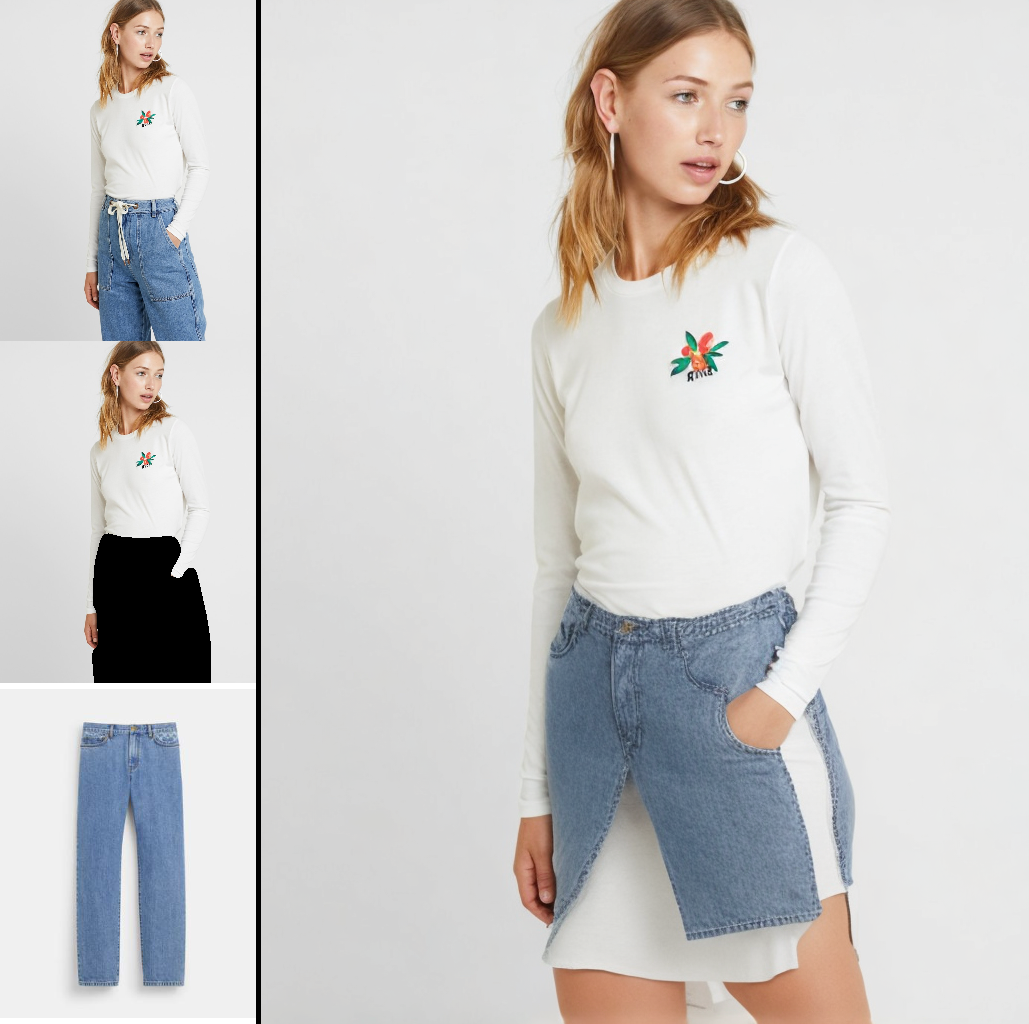

c:\Users\coldbrew\.conda\envs\vton\lib\site-packages\huggingface_hub\file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\coldbrew\.conda\envs\vton\lib\site-packages\diffusers\models\modeling_utils.py:108: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by

Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]

Downloaded zhengchong/CatVTON to C:\Users\coldbrew\.cache\huggingface\hub\models--zhengchong--CatVTON\snapshots\2969fcf85fe62f2036605716f0b56f0b81d01d79


c:\Users\coldbrew\VTON-project\CatVTON\model\SCHP\__init__.py:93: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(ckpt_path, map_location='cpu')['state

In [ ]:
#vitonhd
for i in range(1, 3):
    tryon_and_vis("vitonhd", f"C:/Users/coldbrew/VTON-project/sample_img/standing_sample/standing_0{i}.jpg", f"C:/Users/coldbrew/VTON-project/sample_img/lower/lower0{i}.jpg", "lower")
for i in range(1, 2):
    tryon_and_vis("vitonhd", f"C:/Users/coldbrew/VTON-project/sample_img/standing_sample/standing_0{i}.jpg", f"C:/Users/coldbrew/VTON-project/sample_img/upper/upper0{i}.jpg", "upper")

In [ ]:
# dresscode
for i in range(1, 3):
    tryon_and_vis("dresscode", f"C:/Users/coldbrew/VTON-project/sample_img/standing_sample/standing_0{i}.jpg", f"C:/Users/coldbrew/VTON-project/sample_img/lower/lower0{i}.jpg", "lower")
for i in range(1, 2):
    tryon_and_vis("dresscode", f"C:/Users/coldbrew/VTON-project/sample_img/standing_sample/standing_0{i}.jpg", f"C:/Users/coldbrew/VTON-project/sample_img/upper/upper0{i}.jpg", "upper")

In [ ]:
# mix
for i in range(1, 3):
    tryon_and_vis("dresscode", f"C:/Users/coldbrew/VTON-project/sample_img/standing_sample/standing_0{i}.jpg", f"C:/Users/coldbrew/VTON-project/sample_img/lower/lower0{i}.jpg", "lower")
for i in range(1, 2):
    tryon_and_vis("dresscode", f"C:/Users/coldbrew/VTON-project/sample_img/standing_sample/standing_0{i}.jpg", f"C:/Users/coldbrew/VTON-project/sample_img/upper/upper0{i}.jpg", "upper")

### 앉음 기준

In [ ]:
#vitonhd
for i in range(1, 3):
    tryon_and_vis("vitonhd", f"C:/Users/coldbrew/VTON-project/sample_img/sitting_sample/sample0{i}.jpg", f"C:/Users/coldbrew/VTON-project/sample_img/lower/lower0{i}.jpg", "lower")
for i in range(1, 2):
    tryon_and_vis("vitonhd", f"C:/Users/coldbrew/VTON-project/sample_img/sitting_sample/sample0{i}.jpg", f"C:/Users/coldbrew/VTON-project/sample_img/upper/upper0{i}.jpg", "upper")

In [ ]:
# dresscode
for i in range(1, 3):
    tryon_and_vis("dresscode", f"C:/Users/coldbrew/VTON-project/sample_img/sitting_sample/sample0{i}.jpg", f"C:/Users/coldbrew/VTON-project/sample_img/lower/lower0{i}.jpg", "lower")
for i in range(1, 2):
    tryon_and_vis("dresscode", f"C:/Users/coldbrew/VTON-project/sample_img/sitting_sample/sample0{i}.jpg", f"C:/Users/coldbrew/VTON-project/sample_img/upper/upper0{i}.jpg", "upper")

In [ ]:
# mix
for i in range(1, 3):
    tryon_and_vis("dresscode", f"C:/Users/coldbrew/VTON-project/sample_img/sitting_sample/sample0{i}.jpg", f"C:/Users/coldbrew/VTON-project/sample_img/lower/lower0{i}.jpg", "lower")
for i in range(1, 2):
    tryon_and_vis("dresscode", f"C:/Users/coldbrew/VTON-project/sample_img/sitting_sample/sample0{i}.jpg", f"C:/Users/coldbrew/VTON-project/sample_img/upper/upper0{i}.jpg", "upper")